**Refer to the `./README.md` file for citations and additional details.**

## Climate data - GSWP3 vs. VCG temperature observations

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Tabular data handling
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path  # Path handling

#### Load model data

In [2]:
# Case ID
case_id = "BOR1"

# Path to concatenated model output NetCDF
default_model_output_path = Path("./model_data/history_output_nc/bor1-1000y-allpfts.h0.0001-1001.nc")
# Path to default model climate forcing
default_model_cforcing_path = Path("./model_data/input/GSWP3v1/BOR1/")

In [3]:
# Load netcdf data
start_time = time.time()

default_model_out_data = xr.open_mfdataset(default_model_output_path, decode_times=True)

default_climate_data = xr.open_mfdataset(f'{default_model_cforcing_path}/*{case_id}*.nc',
                                         concat_dim='time',
                                         combine='nested',
                                         decode_times=True
                                        )

print(f"--- Time it took to read the data: {round(float(time.time() - start_time), 3)} seconds ---")

--- Time it took to read the data: 44.857 seconds ---


#### Download and unpack observation data

In [4]:
# Site name in observational dataset
site_name_vcg = "Fauske"

In [5]:
import urllib.request
import shutil

temp_zip_path = Path("./observation_data/temperature.zip")
precip_zip_path = Path("./observation_data/precipitation.zip")

# If not already there, download the files
if not temp_zip_path.is_file():
    with urllib.request.urlopen("https://osf.io/download/ydbfg/") as response, open(Path("./observation_data/temperature.zip"), 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

if not precip_zip_path.is_file():
    with urllib.request.urlopen("https://osf.io/download/cns8k/") as response, open(Path("./observation_data/precipitation.zip"), 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

In [6]:
import zipfile

# If not already there, unzip csv files
temp_unzip_path = Path("./observation_data/temperature")
precip_unzip_path = Path("./observation_data/precipitation")

if not temp_unzip_path.is_dir() and temp_zip_path.is_file():
    with zipfile.ZipFile(temp_zip_path, 'r') as temp_zip:
        temp_zip.extractall(temp_unzip_path)
        
if not precip_unzip_path.is_dir() and precip_zip_path.is_file():
    with zipfile.ZipFile(precip_zip_path, 'r') as precip_zip:
        precip_zip.extractall(precip_unzip_path)

#### Read observation data

In [7]:
obs_temperature_df = pd.read_csv(Path(f"{temp_unzip_path}/Temperature.csv"), low_memory=False)
obs_precipitation_df = pd.read_csv(Path(f"{precip_unzip_path}/Precipitation.csv"), low_memory=False)

#### Plot layout and save path settings

In [8]:
# Define folder for saving plots
plot_save_path = Path("./output_plots/")

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

In [9]:
# Set general plotting optionscm = 1/2.54  # centimeters in inches
cm = 1/2.54  # centimeters in inches
DPI = 100
FIG_SIZE_CM = (9.5*cm, 7*cm)
TICK_LABEL_FONT_SIZE = 9
AX_LABEL_FONT_SIZE = 11
TITLE_FONT_SIZE = 12

In [10]:
obs_temperature_df.head()

,date,siteID,logger,value,flag
0,2008-10-02T04:00:00Z,Alrust,temp200cm,1.228577,NaN
1,2008-10-02T04:00:00Z,Alrust,temp30cm,NaN,NaN
2,2008-10-02T04:00:00Z,Alrust,tempsoil,NaN,NaN
3,2008-10-02T04:00:00Z,Alrust,tempabove,NaN,NaN
4,2008-10-02T04:00:00Z,Arhelleren,temp200cm,NaN,NaN


Subset site and 2 m air temperature logger data.

In [11]:
bor1_2m_temp_df = obs_temperature_df[(obs_temperature_df["siteID"] == site_name_vcg) & (obs_temperature_df["logger"] == "temp200cm")].reset_index(drop=True)
print(f"Shape: {bor1_2m_temp_df.shape}")
print(f"Data types:\n{bor1_2m_temp_df.dtypes}")
bor1_2m_temp_df.head()

Shape: (107371, 5)
Data types:
date       object
siteID     object
logger     object
value     float64
flag       object
dtype: object


,date,siteID,logger,value,flag
0,2008-10-02T04:00:00Z,Fauske,temp200cm,2.833099,NaN
1,2008-10-02T05:00:00Z,Fauske,temp200cm,2.950806,NaN
2,2008-10-02T06:00:00Z,Fauske,temp200cm,3.344238,NaN
3,2008-10-02T07:00:00Z,Fauske,temp200cm,3.897919,NaN
4,2008-10-02T08:00:00Z,Fauske,temp200cm,4.255768,NaN


In [12]:
# Convert date column to datetime, only keep date and value columns
bor1_2m_temp_df['date'] = pd.to_datetime(bor1_2m_temp_df['date'])

bor1_2m_temp_df.drop(labels=['siteID', 'logger', 'flag'], axis=1, inplace=True)

print(f"Data types:\n{bor1_2m_temp_df.dtypes}")
bor1_2m_temp_df.head()

Data types:
date     datetime64[ns, UTC]
value                float64
dtype: object


,date,value
0,2008-10-02 04:00:00+00:00,2.833099
1,2008-10-02 05:00:00+00:00,2.950806
2,2008-10-02 06:00:00+00:00,3.344238
3,2008-10-02 07:00:00+00:00,3.897919
4,2008-10-02 08:00:00+00:00,4.255768


Text(0, 0.5, '2m air temperature [°C]')

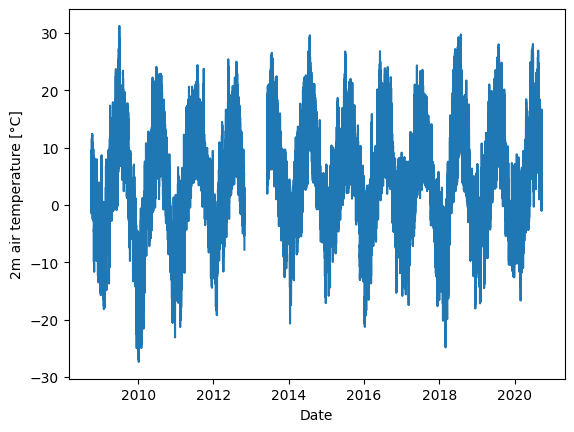

In [13]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(bor1_2m_temp_df['date'], 
        bor1_2m_temp_df['value']
       )
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")

In [14]:
# Calculate daily mean
obs_temp_daily_mean = bor1_2m_temp_df.groupby(pd.Grouper(key='date', freq='D'))['value'].mean()

<AxesSubplot:xlabel='date'>

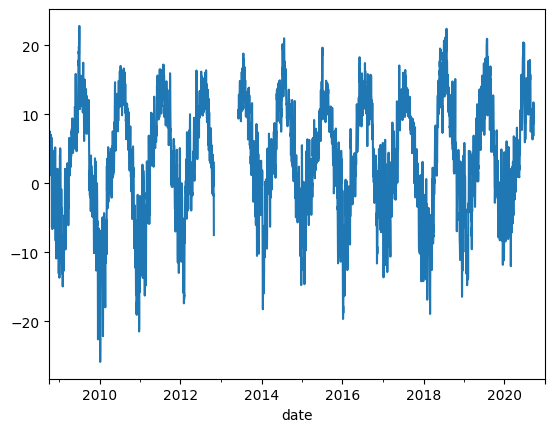

In [15]:
# Quick visualization
obs_temp_daily_mean.plot()

#### GSWP3
Load data from xarray Dataset into a pandas DataFrame.

In [16]:
gswp3_df = pd.DataFrame(columns=['date', '2m_temperature', 'precipitation'])

# Subset date, convert to datetime format. Expect a warning due to GSWP3 special NOLEAP calendar format.
gswp3_df['date'] = default_climate_data.indexes['time'].to_datetimeindex()

# Subset temperature, convert to deg. C
gswp3_df['2m_temperature'] = default_climate_data['TBOT'].values.flatten() - 273.15

# Subset precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step)
gswp3_df['precipitation'] = default_climate_data["PRECTmms"].values.flatten() * 10800

/opt/conda/lib/python3.10/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_2768/1561320729.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  gswp3_df['date'] = default_climate_data.indexes['time'].to_datetimeindex()


In [17]:
gswp3_df.head()

,date,2m_temperature,precipitation
0,1901-01-01 00:00:00,-19.455582,0.009320
1,1901-01-01 03:00:00,-19.813324,0.004717
2,1901-01-01 06:00:00,-18.943527,0.000131
3,1901-01-01 09:00:00,-19.007828,0.000000
4,1901-01-01 12:00:00,-20.444199,0.000000


Text(0, 0.5, '2m air temperature [°C]')

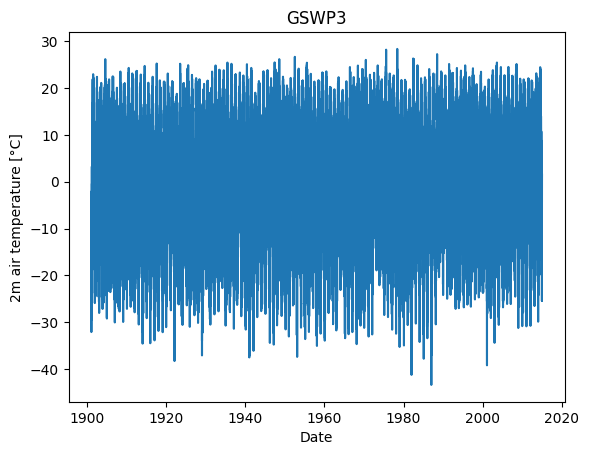

In [18]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(gswp3_df['date'], 
        gswp3_df['2m_temperature']
       )
ax.set_title("GSWP3")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")

In [19]:
# Calculate daily means
gswp3_daily_temp_df = gswp3_df.groupby(pd.Grouper(key='date', freq='D'))['2m_temperature'].mean()

In [20]:
gswp3_daily_temp_df.head()

date
1901-01-01   -19.376417
1901-01-02   -13.008240
1901-01-03    -9.902390
1901-01-04    -9.406570
1901-01-05    -6.409653
Freq: D, Name: 2m_temperature, dtype: float32

(14245.0, 16436.0)

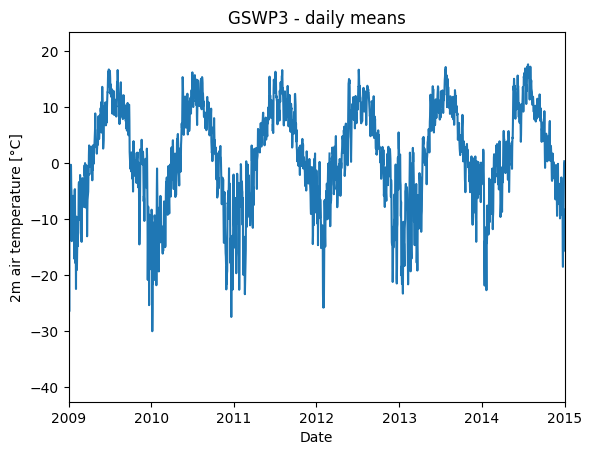

In [21]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(gswp3_daily_temp_df.index, 
        gswp3_daily_temp_df.values
       )
ax.set_title("GSWP3 - daily means")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")
ax.set_xlim(pd.Timestamp(2009, 1, 1), pd.Timestamp(2015, 1, 1))

#### Combine plots

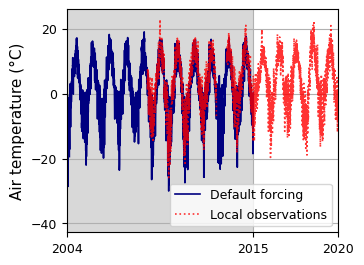

In [43]:
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

# GSWP3
ax.plot(gswp3_daily_temp_df.index, 
        gswp3_daily_temp_df.values,
        linewidth=1.2,
        color="#000080",
        label="Default forcing"
       )

# VCG
ax.plot(obs_temp_daily_mean.index, 
        obs_temp_daily_mean.values,
        linewidth=1.2,
        linestyle="dotted",
        alpha=0.8,
        color="red",
        label="Local observations"
       )

# Add simulation climate forcing period as shaded area
ax.axvspan(xmin=pd.Timestamp(2004, 1, 1),
           xmax=pd.Timestamp(2015, 1, 1),
           alpha=0.3, 
           facecolor="gray",
           edgecolor=None
          )

ax.set_ylabel("Air temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)

#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xlim(pd.Timestamp(2004, 1, 1), pd.Timestamp(2020, 1, 1))
ax.set_xticks(
    [pd.Timestamp(2004, 1, 1),
     pd.Timestamp(2015, 1, 1),
     pd.Timestamp(2020, 1, 1)]
)

ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

import matplotlib.dates as mdates
my_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(my_format)

ax.grid()
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Number of y-ticks
ax.set_yticks([-40, -20, 0, 20])

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_temperatures.png", format='png')

#### Directly compare corresponding values

In [23]:
temp_bias_df = pd.DataFrame(columns=['date', 'vcg_obs'])

# Add values, merge on dates (reset timezone in obs to prevent error)
temp_bias_df['date'] = pd.to_datetime(obs_temp_daily_mean.index).tz_localize(None)
temp_bias_df['vcg_obs'] = obs_temp_daily_mean.values
temp_bias_df = temp_bias_df.join(other=gswp3_daily_temp_df, how='left', on='date')

# Drop rows with missing entries
temp_bias_df = temp_bias_df.dropna(axis=0)
temp_bias_df

,date,vcg_obs,2m_temperature
0,2008-10-02,4.536008,3.557472
1,2008-10-03,4.113730,3.360783
2,2008-10-04,3.102708,1.684246
3,2008-10-05,1.097028,1.410351
4,2008-10-06,4.692994,-0.449127
...,...,...,...
2277,2014-12-27,-12.602125,-15.760235
2278,2014-12-28,-11.807660,-7.395832
2279,2014-12-29,-4.861181,-3.642979
2280,2014-12-30,4.177764,0.061462


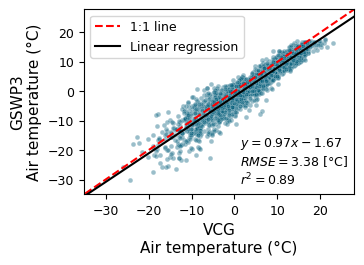

In [44]:
# Plot
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

ax.scatter(temp_bias_df['vcg_obs'],
           temp_bias_df['2m_temperature'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_bias_df['vcg_obs'],
                                                                     temp_bias_df['2m_temperature']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(temp_bias_df['vcg_obs'] - temp_bias_df['2m_temperature'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=4, 
                        pad=0,
                        prop=dict(fontsize=TICK_LABEL_FONT_SIZE)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("VCG\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_ylabel("GSWP3\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
offset = 5 
ax.set_xlim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.set_ylim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_temperature_bias.png", format='png')